In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil
print(tf.__version__)

1.15.0


In [2]:
tf.enable_eager_execution() 

In [2]:
CSV_COLUMN_NAMES = ["time"]+['V'+(i+1).astype(np.str) for i in np.array(range(28))]+['Amount','Class']
CSV_DEFAULTS = [[0.0] for i in np.array(range(30))]+[[0]]
print('CSV_COLUMN_NAMES:{}\nCSV_DEFAULTS:{}'.format(CSV_COLUMN_NAMES,CSV_DEFAULTS))

CSV_COLUMN_NAMES:['time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
CSV_DEFAULTS:[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0]]


In [3]:
FEATURE_NAMES = CSV_COLUMN_NAMES[:-1] # all but first column
feature_cols = [tf.feature_column.numeric_column(key = k) for k in FEATURE_NAMES]
#for i in feature_cols:
#    print(i)  

In [4]:
def parse_row(row):
    fields = tf.decode_csv(records = row, record_defaults = CSV_DEFAULTS)
    features = dict(zip(CSV_COLUMN_NAMES, fields))
    label = features.pop("Class")
    return features, label

def read_dataset(csv_path):
    dataset = tf.data.TextLineDataset(filenames = csv_path).skip(count = 1) # skip header
    dataset = dataset.map(map_func = parse_row)
    return dataset

def train_input_fn(csv_path, batch_size = 128):
    dataset = read_dataset(csv_path)
    dataset = dataset.shuffle(buffer_size = 10000).repeat(count = None).batch(batch_size = batch_size)
    return dataset

def eval_input_fn(csv_path, batch_size = 128):
    dataset = read_dataset(csv_path)
    dataset = dataset.batch(batch_size = batch_size)
    return dataset

In [17]:
# 실제 데이터 확인
# tf.enable_eager_execution() 선언되어 있어야 함.
train_data_check = train_input_fn(csv_path = './input/train_smote.csv')
print(train_data_check.make_one_shot_iterator().get_next()[0])
print(train_data_check.make_one_shot_iterator().get_next()[1][:2])


{'V3': <tf.Tensor: id=1668, shape=(2,), dtype=float32, numpy=array([-2.831034 , -2.4460442], dtype=float32)>, 'V12': <tf.Tensor: id=1650, shape=(2,), dtype=float32, numpy=array([0.4015108, 1.1793581], dtype=float32)>, 'time': <tf.Tensor: id=1675, shape=(2,), dtype=float32, numpy=array([125276.,  40238.], dtype=float32)>, 'V27': <tf.Tensor: id=1666, shape=(2,), dtype=float32, numpy=array([-0.10555946, -0.30745932], dtype=float32)>, 'V21': <tf.Tensor: id=1660, shape=(2,), dtype=float32, numpy=array([0.015308 , 0.1055823], dtype=float32)>, 'V15': <tf.Tensor: id=1653, shape=(2,), dtype=float32, numpy=array([0.39245912, 0.20739678], dtype=float32)>, 'V1': <tf.Tensor: id=1647, shape=(2,), dtype=float32, numpy=array([ 2.0581715, -4.8021445], dtype=float32)>, 'V19': <tf.Tensor: id=1657, shape=(2,), dtype=float32, numpy=array([-0.03328181,  0.77208555], dtype=float32)>, 'V16': <tf.Tensor: id=1654, shape=(2,), dtype=float32, numpy=array([0.15064052, 0.6868173 ], dtype=float32)>, 'V5': <tf.Tensor

# hidden_units=[10,10]

In [5]:
OUTDIR = "credit_trained_LR001_10_10"

config = tf.estimator.RunConfig(
    model_dir=OUTDIR,
    keep_checkpoint_max=20,
    save_summary_steps=40,
    save_checkpoints_steps=200
)
model = tf.estimator.DNNClassifier(
                                  hidden_units=[10, 10],
                                  feature_columns=feature_cols,
                                  optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
                                  config = config)

INFO:tensorflow:Using config: {'_evaluation_master': '', '_save_summary_steps': 40, '_protocol': None, '_task_id': 0, '_device_fn': None, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_service': None, '_experimental_max_worker_delay_secs': None, '_save_checkpoints_secs': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b2a83a5c0>, '_session_creation_timeout_secs': 7200, '_eval_distribute': None, '_model_dir': 'credit_trained_LR001_10_10', '_is_chief': True, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_train_distribute': None, '_num_ps_replicas': 0, '_task_type': 'worker', '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_keep_checkpoint_max': 20, '_experimental_distribute': None, '_save_checkpoints_steps': 200, '_num_worker_replicas': 1}


In [13]:
!rm -r {OUTDIR}

In [17]:
model.train(input_fn = lambda : train_input_fn('./input/train_smote.csv'),
    max_steps = 1000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_10_10/model.ckpt-350
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 350 into credit_trained_LR001_10_10/model.ckpt.
INFO:tensorflow:loss = 1054.7957, step = 351
INFO:tensorflow:global_step/sec: 23.0377
INFO:tensorflow:loss = 546.3751, step = 451 (4.342 sec)
INFO:tensorflow:Saving checkpoints for 550 into credit_trained_LR001_10_10/model.ckpt.
INFO:tensorflow:global_step/sec: 46.3995
INFO:tensorflow:loss = 169.5143, step = 551 (2.159 sec)
INFO:tensorflow:global_step/sec: 35.221
INFO:tensorflow:loss = 211.67862, step = 651 (2.835 sec)
INFO:tensorflow:Saving checkpoints for 750 into credit_trained_LR001_10_10/model.ckpt.
INFO:tensorf

In [18]:
model.evaluate(input_fn = lambda: eval_input_fn('./input/valid.csv'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-09T14:22:32Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_10_10/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-09-14:22:42
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9623428, accuracy_baseline = 0.9981786, auc = 0.9289776, auc_precision_recall = 0.6191958, average_loss = 0.14442687, global_step = 1000, label/mean = 0.0018214136, loss = 18.43526, precision = 0.039481107, prediction/mean = 0.09292555, recall = 0.8433735
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: credit_trained_LR001_10_10/model.ckpt-1000


{'accuracy': 0.9623428,
 'accuracy_baseline': 0.9981786,
 'auc': 0.9289776,
 'auc_precision_recall': 0.6191958,
 'average_loss': 0.14442687,
 'global_step': 1000,
 'label/mean': 0.0018214136,
 'loss': 18.43526,
 'precision': 0.039481107,
 'prediction/mean': 0.09292555,
 'recall': 0.8433735}

In [9]:
generator_predict = model.predict(input_fn = lambda: eval_input_fn('./input/valid.csv'))

In [10]:
for i, y_pred in enumerate(generator_predict):
    if i <= 10:
        # 'classes', 'class_ids', 'logistic', 'all_class_ids', 'probabilities', 'logits', 'all_classes'
        print('classes:{}/class_ids:{}/logistic:{}/probabilities:{}/logits:{}'.format(
               y_pred["classes"],y_pred["class_ids"],y_pred["logistic"]
               ,y_pred["probabilities"],y_pred["logits"]))
print(i)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_10_10/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
classes:[b'0']/class_ids:[0]/logistic:[0.]/probabilities:[1.0000000e+00 2.0295526e-11]/logits:[-24.62062]
classes:[b'0']/class_ids:[0]/logistic:[1.0430813e-06]/probabilities:[9.9999893e-01 1.1312853e-06]/logits:[-13.692155]
classes:[b'0']/class_ids:[0]/logistic:[0.]/probabilities:[1.0000000e+00 8.8405195e-12]/logits:[-25.451675]
classes:[b'0']/class_ids:[0]/logistic:[0.00010321]/probabilities:[9.9989676e-01 1.0317596e-04]/logits:[-9.178971]
classes:[b'0']/class_ids:[0]/logistic:[9.825826e-05]/probabilities:[9.999018e-01 9.827159e-05]/logits:[-9.227677]
classes:[b'0']/class_ids:[0]/logistic:[0.00151905]/probabilities:[0.998481   0.00151901]/logits:[-6.4881754]
classes:[b'0']/class_ids:[0]/logistic:[0.00045696]/pro

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_10_10/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[43783  1703]
 [   13    70]]


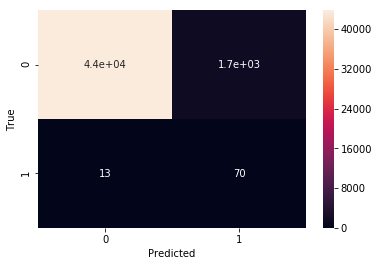

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in model.predict(input_fn=input_fn)]

LABELS = ["0", "1"]

df_eval = pd.read_csv('./input/valid.csv')

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(pd.read_csv('./input/valid.csv')["Class"],get_predictions(model,  lambda: eval_input_fn('./input/valid.csv')))
    with tf.Session() as session:
        cm_out = session.run(cm)
        print(cm_out)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) 
# / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# hidden_units = [10]

In [52]:
OUTDIR = "credit_trained_LR001_10"

config = tf.estimator.RunConfig(
    model_dir=OUTDIR,
    save_summary_steps=10,
    save_checkpoints_steps=100
)
model = tf.estimator.DNNClassifier(
                                  hidden_units=[10],
                                  feature_columns=feature_cols,
                                  optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
                                  config = config)

INFO:tensorflow:Using config: {'_experimental_distribute': None, '_evaluation_master': '', '_model_dir': 'credit_trained_LR001_10', '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_service': None, '_session_creation_timeout_secs': 7200, '_log_step_count_steps': 100, '_save_checkpoints_steps': 100, '_save_summary_steps': 10, '_protocol': None, '_task_id': 0, '_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_train_distribute': None, '_eval_distribute': None, '_num_ps_replicas': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_worker_replicas': 1, '_tf_random_seed': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff73818de48>, '_experimental_max_worker_delay_secs': None, '_device_fn': None}


In [53]:
!rm -r {OUTDIR}

rm: cannot remove 'credit_trained_LR001_10': No such file or directory


In [54]:
model.train(input_fn = lambda : train_input_fn('./input/train_smote.csv'),
    max_steps = 5000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into credit_trained_LR001_10/model.ckpt.
INFO:tensorflow:loss = 1.0466638e-24, step = 1
INFO:tensorflow:Saving checkpoints for 100 into credit_trained_LR001_10/model.ckpt.
INFO:tensorflow:global_step/sec: 19.7499
INFO:tensorflow:loss = 36.430286, step = 101 (5.066 sec)
INFO:tensorflow:Saving checkpoints for 200 into credit_trained_LR001_10/model.ckpt.
INFO:tensorflow:global_step/sec: 29.9724
INFO:tensorflow:loss = 0.0002217642, step = 201 (3.341 sec)
INFO:tensorflow:Saving checkpoints for 300 into credit_trained_LR001_10/model.ckpt.
INFO:tensorflow:global_step/sec: 29.4484
INFO:tensorflow:loss = 1161.4927, step = 301 (3.395 sec)
INFO:tensorflow:Saving checkpoints for 400 into credit_trained_LR001_10/model.ckpt.
I

In [55]:
model.evaluate(input_fn = lambda: eval_input_fn('./input/valid.csv'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-09T13:36:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_10/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-09-13:36:16
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.0024358665, accuracy_baseline = 0.9981786, auc = 0.5008574, auc_precision_recall = 0.50091225, average_loss = 1633.9825, global_step = 5000, label/mean = 0.0018214136, loss = 208568.5, precision = 0.0018225336, prediction/mean = 0.99929744, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: credit_trained_LR001_10/model.ckpt-5000


{'accuracy': 0.0024358665,
 'accuracy_baseline': 0.9981786,
 'auc': 0.5008574,
 'auc_precision_recall': 0.50091225,
 'average_loss': 1633.9825,
 'global_step': 5000,
 'label/mean': 0.0018214136,
 'loss': 208568.5,
 'precision': 0.0018225336,
 'prediction/mean': 0.99929744,
 'recall': 1.0}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_10/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[   28 45458]
 [    0    83]]


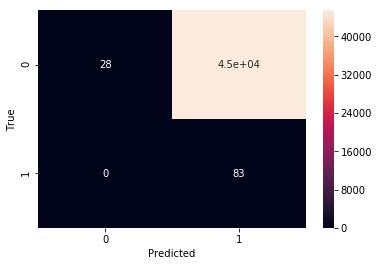

In [56]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in model.predict(input_fn=input_fn)]

LABELS = ["0", "1"]

df_eval = pd.read_csv('./input/valid.csv')

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(pd.read_csv('./input/valid.csv')["Class"],get_predictions(model,  lambda: eval_input_fn('./input/valid.csv')))
    with tf.Session() as session:
        cm_out = session.run(cm)
        print(cm_out)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) 
# / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# hidden_units = [1]

In [57]:
OUTDIR = "credit_trained_LR001_1"

config = tf.estimator.RunConfig(
    model_dir=OUTDIR,
    save_summary_steps=10,
    save_checkpoints_steps=100
)
model = tf.estimator.DNNClassifier(
                                  hidden_units=[1],
                                  feature_columns=feature_cols,
                                  optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
                                  config = config)

INFO:tensorflow:Using config: {'_experimental_distribute': None, '_evaluation_master': '', '_model_dir': 'credit_trained_LR001_1', '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_service': None, '_session_creation_timeout_secs': 7200, '_log_step_count_steps': 100, '_save_checkpoints_steps': 100, '_save_summary_steps': 10, '_protocol': None, '_task_id': 0, '_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_train_distribute': None, '_eval_distribute': None, '_num_ps_replicas': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_worker_replicas': 1, '_tf_random_seed': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff799417780>, '_experimental_max_worker_delay_secs': None, '_device_fn': None}


In [58]:
!rm -r {OUTDIR}

rm: cannot remove 'credit_trained_LR001_1': No such file or directory


In [59]:
model.train(input_fn = lambda : train_input_fn('./input/train_smote.csv'),
    max_steps = 5000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into credit_trained_LR001_1/model.ckpt.
INFO:tensorflow:loss = 161896.97, step = 1
INFO:tensorflow:Saving checkpoints for 100 into credit_trained_LR001_1/model.ckpt.
INFO:tensorflow:global_step/sec: 21.018
INFO:tensorflow:loss = 116.60617, step = 101 (4.765 sec)
INFO:tensorflow:Saving checkpoints for 200 into credit_trained_LR001_1/model.ckpt.
INFO:tensorflow:global_step/sec: 30.0563
INFO:tensorflow:loss = 123.13315, step = 201 (3.323 sec)
INFO:tensorflow:Saving checkpoints for 300 into credit_trained_LR001_1/model.ckpt.
INFO:tensorflow:global_step/sec: 39.0098
INFO:tensorflow:loss = 72.859024, step = 301 (2.563 sec)
INFO:tensorflow:Saving checkpoints for 400 into credit_trained_LR001_1/model.ckpt.
INFO:tensorflo

In [60]:
model.evaluate(input_fn = lambda: eval_input_fn('./input/valid.csv'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-09T13:39:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-09-13:39:14
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.0018214136, accuracy_baseline = 0.9981786, auc = 0.49994504, auc_precision_recall = 0.0009108068, average_loss = 0.7155252, global_step = 5000, label/mean = 0.0018214136, loss = 91.33269, precision = 0.0018214136, prediction/mean = 0.5111016, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: credit_trained_LR001_1/model.ckpt-5000


{'accuracy': 0.0018214136,
 'accuracy_baseline': 0.9981786,
 'auc': 0.49994504,
 'auc_precision_recall': 0.0009108068,
 'average_loss': 0.7155252,
 'global_step': 5000,
 'label/mean': 0.0018214136,
 'loss': 91.33269,
 'precision': 0.0018214136,
 'prediction/mean': 0.5111016,
 'recall': 1.0}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained_LR001_1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[    0 45486]
 [    0    83]]


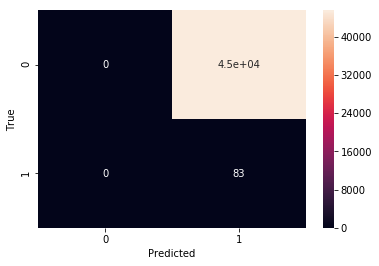

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in model.predict(input_fn=input_fn)]

LABELS = ["0", "1"]

df_eval = pd.read_csv('./input/valid.csv')

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(pd.read_csv('./input/valid.csv')["Class"],get_predictions(model,  lambda: eval_input_fn('./input/valid.csv')))
    with tf.Session() as session:
        cm_out = session.run(cm)
        print(cm_out)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) 
# / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Train SMOTE Class별 Label확인

In [17]:
df_train_smote = pd.read_csv('./input/train_smote.csv')

In [19]:
df_train_smote.Class.value_counts()

1    181971
0    181971
Name: Class, dtype: int64

In [31]:
data = pd.read_csv('./input/creditcard.csv')

In [32]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=27)
print('df_train :', df_train.shape)
print('df_valid :', df_valid.shape)
print('df_test :', df_test.shape)

NameError: name 'train_test_split' is not defined

In [28]:
# pandas_input_fn
def pd_input_fn(df,batch_size=128,num_epochs=5,shuffle=True):
    return tf.estimator.inputs.pandas_input_fn(
      x=df[FEATURE_NAMES],
      y=df[LABEL_NAME],
      batch_size = batch_size,
      num_epochs = num_epochs,
      shuffle = shuffle,
      queue_capacity = 1000,
      num_threads = 1
  )

In [ ]:
OUTDIR = "credit-prac"

config = tf.estimator.RunConfig(
    model_dir = OUTDIR,
    tf_random_seed = 1,
    save_checkpoints_steps = 100
)

model = tf.estimator.DNNClassifier(
  hidden_units = [10,10], 
  feature_columns = feature_cols, 
  config = config
)

In [ ]:
%%time
tf.logging.set_verbosity(tf.logging.INFO) 
shutil.rmtree(path = OUTDIR, ignore_errors = True)

model.train(input_fn = pd_input_fn(df=df_train,num_epochs=5), steps = 500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from credit_trained/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[70783   287]
 [   77    55]]


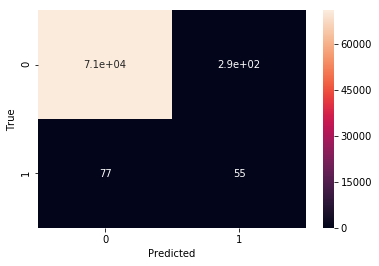

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in model.predict(input_fn=input_fn)]

LABELS = [
    "0", "1"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(df_eval["Class"],get_predictions(model,  lambda: eval_input_fn('./input/creditcard_eval.csv')))
    with tf.Session() as session:
        cm_out = session.run(cm)
        print(cm_out)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) 
# / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

In [ ]:
tf.estimator.RunConfig